# Principal component analysis of ensemble forecast fields (GRIB)

In this example we will perform a principal component (PCA) analysis on ensemble forecast fields stored in GRIB format. We will use a combination of Metview, numpy and scipy to achieve this.

In [1]:
import metview as mv
import numpy as np
from scipy import linalg as LA

File *z500_ens.grib* contains 500 hPa geopotential ECMWF ensemble forecast (50 perturbed and a control member) for a given timestep (+96h). We read this data into a [Fieldset](https://confluence.ecmwf.int/display/METV/Fieldset+Functions) which is Metview's own class to handle GRIB data.

In [2]:
fs = mv.read("./z500_ens.grib")

We will compute the principal components (PC) using *numpy* and *scipy*. First we load the fields into a numpy array.

In [3]:
v = fs.values()
print(v.shape)

(51, 3266)


For the PCA we center the data, create the covariance matrix and compute the eigenvalues and eigenvectors of it.

In [4]:
v -= np.mean(v, axis = 0)  
cov = np.cov(v, rowvar = False)
evals , evecs = LA.eigh(cov)

The resulting *evecs* array stores the eigenvectors as columns. The eigenvectors are guaranteed to be orthonormal but not yet sorted according to the eigenvalues. So we sort them in descending order. 

In [5]:
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
evals = evals[idx]

This sorted set of eigenvectors forms the principal components of the examined fields. If we print the *explained variance* of the first few PCs we can conclude that the first two PCs are particularly dominant explaining almost 70% of the total variance. We will plot these PCs together with the ensemble mean and spread (i.e. standard deviation) to get a more detailed picture of the main flow patterns in the ENS forecast.

In [6]:
evals[:10]*100/evals.sum()

array([54.49451851, 14.93586953,  7.88068224,  6.16600524,  3.83589734,
        1.81716285,  1.56162616,  1.44788584,  1.01362975,  0.78237414])

In order to plot the PCs with Metview we convert them back into fieldsets by creating a copy of the first two fields of our original fieldset and setting the values accordingly. Please note that the metadata of the new fields is not accurate but it is still perfectly fine for plotting purposes. 

In [7]:
g = fs[0:2]
g[0] = g[0].set_values(evecs[:,0]) 
g[1] = g[1].set_values(evecs[:,1])

To plot the data, we need to tell Metview to send the plot to Jupyter.

In [8]:
mv.setoutput('jupyter')

Plotting is performed through Metview's interface to the [Magics](https://confluence.ecmwf.int/display/MAGP/Magics) library developed at ECMWF. We will first define the view parameters (by default we will get a global map in cylindrical projection).

In [9]:
# shaded land to make the points stand out more
grey_land_shading = mv.mcoast(
    map_coastline_land_shade        = "on",
    map_coastline_land_shade_colour = "grey",
    map_grid_latitude_increment     = 10,
    map_grid_longitude_increment    = 10,
    map_grid_colour                 = "charcoal"
)

area_view = mv.geoview(
    map_area_definition = 'corners',
    area = [30,-40.87,65,20],
    coastlines = grey_land_shading
)

Then we define a 2x2 layout based on the map we defined above.

In [10]:
dw = mv.plot_superpage(pages = mv.mvl_regular_layout(area_view,2,2,1,1))

To highlight the details of the PCs we use Magics' powerful contouring routine to assign colours based on the magnitude of the differences.

In [11]:
cont_pc = mv.mcont(
    legend     = "on",
    contour_line_colour = "black",
    contour_highlight = "off",
    contour_max_level = 0.06,
    contour_min_level = -0.06,
    contour_shade = "on",
    contour_shade_colour_method = "palette",
    contour_shade_method = "area_fill",
    contour_shade_palette_name= "eccharts_red_blue2_10")


Finally, we plot each field with a custom title. We compute the ensemble mean and spread on the fly with fieldset functions from Metview.  

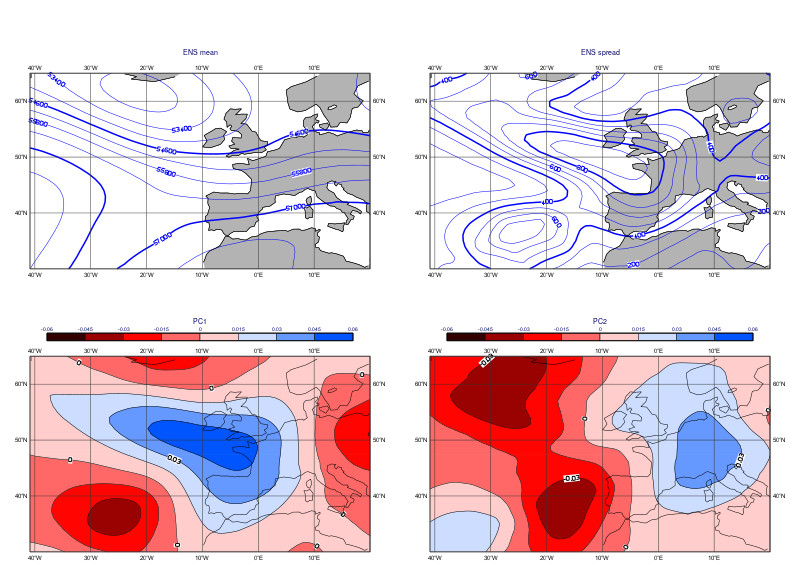

In [12]:
mv.plot(dw[0], fs.mean(),  mv.mtext(text_line_1 = "ENS mean"),
        dw[1], fs.stdev(), mv.mtext(text_line_1 = "ENS spread"),
        dw[2], g[0], cont_pc, mv.mtext(text_line_1 = "PC1"),
        dw[3], g[1], cont_pc, mv.mtext(text_line_1 = "PC2"))

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)